In [12]:
from import_setup import *
from electrolysis import *
from methanation import *
from wwtp import *


from chp import *
chps = List()
for i, chp_name in enumerate(chp_gas_storage_rules_dict.keys()):
    chps.append(
        CHP(chp_max_gas_power_uptake_dict[chp_name],chp_efficiency_rules[i],
        maintenance_time_on_failure=chp_failures_dict[chp_name][1],
        avg_time_betw_failure=chp_failures_dict[chp_name][0],
        avg_time_diff=np.mean(df["Time_diff / h"].values.astype(float))))

# TODO: in the future, these variables can also be handled by a separate function/script
# for easier handling, different dataframes are created for the most needed quantities
# for type safety, the variables extracted from df are all specified as float arrays
# variables that are written into a new line every timestep
time_arr = df["Time / h"].values.astype(float)
time_diff = df["Time_diff / h"].values.astype(float)
raw_price = df["Price / EURO/MWh"].values.astype(float)
gas_production = df["Gas Production / Nm^3/h"].values.astype(float)
heat_demand_fermenter = df["Fermenter Heat Demand / kW"].values.astype(float)
chp_run_time = np.ones((time_arr.shape[0], num_chps))
chp_load = np.zeros((time_arr.shape[0], num_chps))
chp_el_power = np.zeros((time_arr.shape[0], num_chps))
chp_th_power = np.zeros((time_arr.shape[0], num_chps))
chp_gas_consumption = np.zeros((time_arr.shape[0], num_chps))
maintenance = np.zeros((time_arr.shape[0], num_chps))
maintenance_time_per_rule = np.zeros((time_arr.shape[0], num_chps, num_maintenance_rules))
gas_storage = np.zeros(time_arr.shape)
gas_storage_tendency = np.zeros(time_arr.shape)
flare_run_time = np.zeros(time_arr.shape[0])
flare_gas_consumption = np.zeros(time_arr.shape[0])
temp_heat_net = np.zeros(time_arr.shape[0])
boiler_load = np.zeros((time_arr.shape[0], num_boilers))
boiler_th_power = np.zeros((time_arr.shape[0], num_boilers))
boiler_run_time = np.zeros((time_arr.shape[0], num_boilers))
boiler_gas_consumption = np.zeros((time_arr.shape[0], num_boilers))

# variables that are overwritten every timestep
run_time_between_maintenance = np.zeros([num_chps, chp_maintenance_rules.shape[1]], dtype=float)
maintenance_remaining_failure = np.zeros(num_chps, dtype=float)



# initialize operator
from load_scheduler import *
flare_threshold = 1800 # Nm^3 (1800 1800 is the safety limit of the 3000 Nm^3 capacity of gas holder 1). If both tanks are available (8000 Nm^3 total volume), the threshold is 6500 Nm^3
chp_gas_storage_rules_dict = {
    "chp1": {
        # name:   threshold, tendency, gas load
        "rule1": [1200, 0, 1], # above 1200 Nm^3, tendency doesn't matter, full load 
        "rule2": [800, 0, 0.54] # above 800 Nm^3, tendency positive, 50% load
    },
    "chp2": {
        # name:   threshold, tendency, gas load
        "rule1": [1200, 0, 1], # above 1200 Nm^3, tendency doesn't matter, full load 
        "rule2": [800, 0, 0.54] # above 800 Nm^3, tendency positive, 50% load
    },
    "chp3": {
        # name:   threshold, tendency, gas load
        "rule1": [500, 0, 1], # above 500 Nm^3, tendency doesn't matter, full load
        "rule2": [800, 0, 0.55] # above 800 Nm^3, tendency doesn't matter, 50% load
    }, 
    "chp4": {
        # name:   threshold, tendency, gas load
        "rule1": [1000, 0, 1], # above 1000 Nm^3, tendency doesn't matter, full load
        "rule2": [800, 0, 0.55] # above 800 Nm^3, tendency doesn't matter, 50% load
    }
    }
chp_gas_storage_rules, _,_ = get_rules(chp_gas_storage_rules_dict)
operator = LoadScheduler(flare_threshold, chp_gas_storage_rules, chp_maintenance_rules, chps, boilers, heat_net, price_threshold=80)
gas_storage[0] = 2402.79 # Nm^3
gas_storage_tendency[0] = 1 # Nm^3/h
temp_heat_net[0] = 70 # °C


logging.debug("Starting simulation")
# Start the stopwatch
tic = time.time()

for k in range(1, len(time_arr)):
    # old_run_time=np.array([1,1]), old_maintenance=np.array([0,0]), old_gas_storage=1200, new_time_diff=1, new_price=0.1
    # run scheduler
    logging.debug("now calculating timestep: " + str(k))

    # calculate new temperature of heat network based on heat demand of fermenter
    temp_heat_net[k] = heat_net.new_temperature(heat_demand_fermenter[0],temp_heat_net[k-1],mass_flow_heat_net)
    # schedule runnning of chps and flare (and boilers)
    chp_run_time[k,:], maintenance[k,:], chp_load[k,:], maintenance_time_per_rule[k,:], _, _, _,\
        run_time_between_maintenance, boiler_load[k,:], boiler_run_time[k,:], flare_run_time[k], flare_gas_consumption[k] = \
        operator.schedule_production(chp_run_time[k-1,:], maintenance[k-1,:], gas_storage[k-1], gas_storage_tendency[k-1], time_diff[k], raw_price[k], maintenance_remaining_failure, flare_run_time[k-1], boiler_run_time[k-1,:], temp_heat_net[k], mass_flow_heat_net, 80, biogas_obj)
    # run CHPs
    for i in range(num_chps):
        chp_load[k,i], chp_el_power[k,i], chp_th_power[k,i], chp_gas_consumption[k,i], maintenance_remaining_failure[i], chp_run_time[k,:] = \
                chps[i].run(chp_load[k,i], run_time_between_maintenance[i,:], maintenance_remaining_failure[i], chp_run_time[k,:], time_diff[k], biogas_obj.h_u)
    # run flare
    flare_gas_consumption[k] = flare.run(flare_gas_consumption[k])

    # run Boilers
    for i in range(num_boilers):
        boiler_load[k,i], boiler_th_power[k,i], boiler_gas_consumption[k,i], boiler_run_time[k,i] = \
            boilers[i].run(boiler_load[k,i], boiler_run_time[k,i], time_diff[k], biogas_obj.h_u)
    
    # calculate new temperature of heat network based on heat demand of fermenter
    temp_heat_net[k] = heat_net.new_temperature(np.sum(boiler_th_power[k,:])+np.sum(chp_th_power[k,:]),temp_heat_net[k-1],mass_flow_heat_net)

    # calculate new gas storage.
    # TODO: For now, the gas storage can be computed in main. If future complexity is coming in (if some costs are associated with it etc...) the gas storage needs to be separated into another object
    gas_storage[k] = gas_storage[k-1] + (gas_production[k] - chp_gas_consumption[k,:].sum() - flare_gas_consumption[k]) * time_diff[k] # in Nm^3
    gas_storage_tendency[k] = gas_storage[k] - gas_storage[k-1]

    # every 1000 timesteps, print the current timestep as info log level
    if k % 10000 == 0:
        logging.info("timestep: " + str(k) + " of " + str(len(time_arr)))

    # For debugging, print a timestep near the problem to stop sim there
    if time_arr[k] == 7100*3:
        logging.debug("timestep: " + str(k) + " of " + str(len(time_arr)))

# Stop the stopwatch
toc = time.time()

logging.info('Simulation took {:3.2f}s to compute, with {} steps'.format(toc-tic, len(time_arr)))

INFO:root:timestep: 10000 of 35036
INFO:root:timestep: 20000 of 35036
INFO:root:timestep: 30000 of 35036
INFO:root:Simulation took 11.01s to compute, with 35036 steps


In [13]:
operator.chp_gas_storage_rules

array([[[1.2e+03, 0.0e+00, 1.0e+00],
        [8.0e+02, 0.0e+00, 5.4e-01]],

       [[1.2e+03, 0.0e+00, 1.0e+00],
        [8.0e+02, 0.0e+00, 5.4e-01]],

       [[5.0e+02, 0.0e+00, 1.0e+00],
        [8.0e+02, 0.0e+00, 5.5e-01]],

       [[1.0e+03, 0.0e+00, 1.0e+00],
        [8.0e+02, 0.0e+00, 5.5e-01]]])

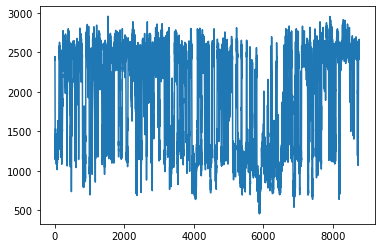

In [14]:
import matplotlib.pyplot as plt
plt.plot(time_arr, gas_storage)
plt.show()

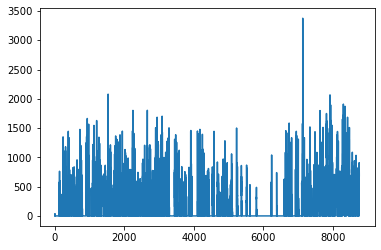

In [15]:
plt.plot(time_arr, flare_gas_consumption)

In [16]:
df["Stromerzeugung BHKW1 calc / kWh"] = chp_el_power[:,0] / 4
df["Stromerzeugung BHKW2 calc / kWh"] = chp_el_power[:,1] / 4
df["Stromerzeugung BHKW3 calc / kWh"] = chp_el_power[:,2] / 4
df["Stromerzeugung BHKW4 calc / kWh"] = chp_el_power[:,3] / 4
df["Stromerzeugung BHKW sum calc / kWh"] = chp_el_power.sum(axis=1) / 4

<AxesSubplot:>

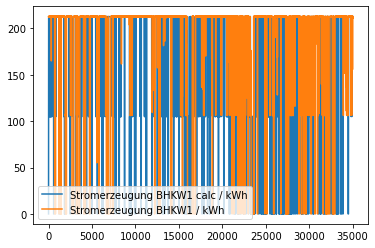

In [17]:
# %matplotlib widget
df[["Stromerzeugung BHKW1 calc / kWh", "Stromerzeugung BHKW1 / kWh"]].plot()

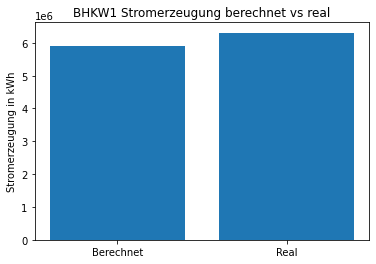

In [18]:
power_calc=df["Stromerzeugung BHKW1 calc / kWh"].sum()
power_real=df["Stromerzeugung BHKW1 / kWh"].sum()
# print(f"Berechnete Stromerzeugung 2020: {power_calc:.2f} kWh")
# print(f"Reale Stromerzeugung 2020: {power_real:.2f} kWh")
plt.bar(["Berechnet", "Real"], [power_calc, power_real])
plt.title("BHKW1 Stromerzeugung berechnet vs real")
plt.ylabel("Stromerzeugung in kWh")
plt.show()


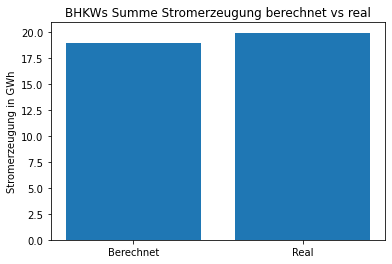

In [19]:
df["Stromerzeugung sum / kWh"] = df["Stromerzeugung BHKW1 / kWh"] + df["Stromerzeugung BHKW2 / kWh"] + df["Stromerzeugung BHKW3 / kWh"] + df["Stromerzeugung BHKW4 / kWh"]
power_calc_sum=df["Stromerzeugung BHKW sum calc / kWh"].sum()/1e6
power_real_sum=df["Stromerzeugung sum / kWh"].sum()/1e6
plt.bar(["Berechnet", "Real"], [power_calc_sum, power_real_sum])
plt.title("BHKWs Summe Stromerzeugung berechnet vs real")
plt.ylabel("Stromerzeugung in GWh")
plt.show()

In [20]:
power_calc_sum*1e7

189674465.0514

Sum of power production with full tank capacity: 194297874.08 kWh  
Sum of power production with new (low) tank capacity and status-quo rules: 189674465.05 kWh  
Sum of power production with new (low) tank capacity and optimized rules: 191838724.85 kWh  

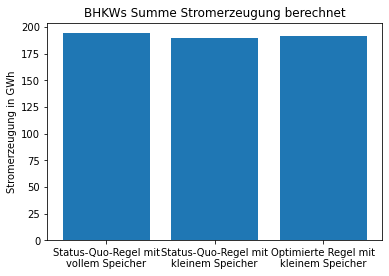

In [22]:
results_list = [194297874.08/1e6, 189674465.05/1e6, 191838724.85/1e6]
plt.bar(["Status-Quo-Regel mit\nvollem Speicher", "Status-Quo-Regel mit\nkleinem Speicher", "Optimierte Regel mit\nkleinem Speicher"], results_list)
plt.title("BHKWs Summe Stromerzeugung berechnet")
plt.ylabel("Stromerzeugung in GWh")
plt.show()

In [23]:
results_list[2]/results_list[1]

1.011410390952886

In [10]:
gas_storage[gas_storage < 0]

array([], dtype=float64)

In [19]:
boilers[0].calculate_consumption(1,biogas_obj.h_u)

409.2276830491474

In [8]:
print(df["Stromerzeugung BHKW1 calc / kWh"].mean())
print(df["Stromerzeugung BHKW1 / kWh"].mean())

168.32642868472777
180.06112541385323


In [12]:
def expand_time_horizon(df, factor: int):
    """
    Expand the time horizon of a DataFrame by a `factor`. The new values in the dataframe are just copies of the old ones, while the time is increasing in the same intervals as the original dataframe
    Arguments:
        df: pd.DataFrame with data and a column "Time / h"
        factor: int, factor to expand the DataFrame
    Returns:
        pd.DataFrame. Extended DataFrame.
    """

    df_to_add = df.copy(deep=True)
    if df_to_add["Time / h"].min() <= 0:
        print("Dropping all data which is at Time <= 0")
        df_to_add = df_to_add[df_to_add["Time / h"] > 0]
    add_time = df_to_add["Time / h"]

    df_concat = df.copy(deep=True)
    # build up df_concat
    for i in range(factor-1):
        max_time = df_concat["Time / h"].max()
        df_to_add["Time / h"] = add_time + max_time
        df_concat = pd.concat([df_concat, df_to_add], ignore_index=True)
    
    # fix timestamps
    start_time = df_concat["Time"][0]
    df_concat["Time"] = start_time + pd.to_timedelta(df_concat["Time / h"], unit='H')

    return df_concat


def apply_inflation(orig_df: pd.DataFrame, apply_df: pd.DataFrame, col: str, inflation: float, time_span: float = 8760.0) -> pd.DataFrame:
    """
    Inflate value from `col` in `apply_df` by factor `inflation` per `time_span`
    `orig_df` is needed to distinguish between given data and extrapolated data
    Arguments:
        df: pd.DataFrame, must contain column "Time / h" and `col`
        col: str, string with column name to be inflated
        inflation: float, inflation factor (e.g. 0.05)
        time_span: float, time over which inflation occurs
    Returns:
        pd.DataFrame. DataFrame with inflated values
    """
    # make a deep copy in order to leave the original dataframe untouched
    apply_df = apply_df.copy(deep=True)

    apply_start_row = orig_df[col].shape[0]+1
    orig_time = orig_df["Time / h"][orig_df["Time / h"].shape[0]-1]
    apply_df.loc[apply_start_row:,col] = apply_df.loc[apply_start_row:,col] * (1 + (apply_df["Time / h"][apply_start_row:] - orig_time) / time_span * inflation)
    return apply_df

def extrapolate_cyclic_data(orig_df: pd.DataFrame, expand_df: pd.DataFrame, col: str, volatility: float, inflation: float, time_span: float) -> pd.DataFrame:
    """
    Extrapolate cyclic data from `col` in `expand_df` by factor `volatility` and `inflation` per `time_span` with decomposition in cyclic and fluctuating component over Weekdays
    `orig_df` is needed to distinguish between given data and extrapolated data
    Arguments:
        orig_df: pd.DataFrame, must contain columns "Time", "Time / h" and `col`
        expand_df: pd.DataFrame, must contain columns "Time", "Time / h" and `col`
        col: str, string with column name to be extrapolated
        volatility: float, volatility factor (e.g. 0.05) for fluctuating component. Increasing over `time_span`
        inflation: float, inflation factor (e.g. 0.05) for cyclic component. Increasing over `time_span`
        time_span: float, time over which inflation and volatility factor occurs
    Returns:
        pd.DataFrame. Extended DataFrame.
    """
    # make a deep copy in order to leave the original dataframe untouched
    expand_df = expand_df.copy(deep=True)
    
    orig_df["Weekday"] = pd.to_datetime(orig_df["Time"]).dt.weekday
    avg = orig_df.groupby(["Weekday"])[col].mean()

    # decompose into cyclic ("Weekday avg") and fluctuating component
    expand_df["Weekday"] = pd.to_datetime(expand_df["Time"]).dt.weekday
    expand_df["Weekday avg"] = expand_df["Weekday"].map(avg)
    expand_df["Fluctuation"] = expand_df[col] - expand_df["Weekday avg"]

    # figure out where to start extrapolating
    extrap_start_row = orig_df[col].shape[0]+1
    orig_time = orig_df["Time / h"][orig_df["Time / h"].shape[0]-1]

    # extrapolate only rows not given by original data
    expand_df.loc[extrap_start_row:,"Weekday avg"] = expand_df.loc[extrap_start_row:,"Weekday avg"] * (1 + (expand_df["Time / h"][extrap_start_row:] - orig_time) / time_span * inflation)
    expand_df.loc[extrap_start_row:,"Fluctuation"] = expand_df.loc[extrap_start_row:,"Fluctuation"] * (1 + (expand_df["Time / h"][extrap_start_row:] - orig_time) / time_span * volatility)
    
    # recompose by adding cyclic and fluctuating component
    expand_df[col] = expand_df["Weekday avg"] + expand_df["Fluctuation"]

    # clean up
    expand_df = expand_df.drop(columns=["Weekday", "Weekday avg", "Fluctuation"])
    orig_df = orig_df.drop(columns=["Weekday"])

    return expand_df
    
# df["Price"] = np.ones(df["Time"].shape[0])
df_new = expand_time_horizon(df, 20)
# df_new.to_csv("test.csv")

In [18]:
df_new2 = extrapolate_cyclic_data(df, df_new, "Real Price / EURO/MWh", 0, 0.05, 8760.0)
df_new2

Time  Gas Production / Nm^3/h  \
0      2018-01-01 00:30:00              1210.770000   
1      2018-01-01 00:45:00              1210.770000   
2      2018-01-01 01:00:00              1226.960000   
3      2018-01-01 01:15:00              1171.170000   
4      2018-01-01 01:30:00              1047.750000   
...                    ...                      ...   
700875 2037-12-26 03:15:00              1216.350138   
700876 2037-12-26 03:30:00              1270.818742   
700877 2037-12-26 03:45:00              1460.417699   
700878 2037-12-26 04:00:00              1364.150984   
700879 2037-12-26 04:15:00              1312.989671   

        Fermenter Heat Demand / kW   Time / h  Time_diff / h  \
0                      1566.022583       0.25           0.25   
1                      1814.289551       0.50           0.25   
2                      1935.617188       0.75           0.25   
3                      1796.189819       1.00           0.25   
4                      1835.823608       1.25           0.25   
...                            ...        ...            ...   
700875                  343.994659  175179.00           0.25   
700876                  343.994659  175179.25           0.25   
700877                 1566.022583  175179.50           0.25   
700878                 1814.289551  175179.75           0.25   
700879                 1935.617188  175180.00           0.25   

        Price / EURO/MWh  Real Price / EURO/MWh  Price  
0                  -5.27              26.767265    1.0  
1                  -5.27              26.767265    1.0  
2                  -5.27              26.767265    1.0  
3                 -29.99              -2.649535    1.0  
4                 -29.99              -2.649535    1.0  
...                  ...                    ...    ...  
700875             48.93             167.852552    1.0  
700876             48.93             167.852667    1.0  
700877             48.93             167.852782    1.0  
700878             48.93             167.852897    1.0  
700879             30.31             145.695212    1.0  

[700880 rows x 8 columns]

<AxesSubplot:xlabel='Time'>

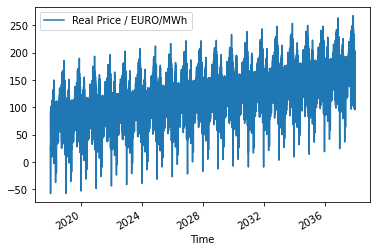

In [19]:
df_new2.plot(x="Time", y="Real Price / EURO/MWh")

In [17]:
class Test:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        # check if self object has all attributes (except dunder attributes) with map function
    
        pass
    
    def __setattr__(self, __name, __value) -> None:
        self.__dict__[__name] = __value
        print([x for x in dir(self) if not x.startswith("__")])
        is_attr = list(map(lambda x: hasattr(self, x), [x for x in dir(self) if not x.startswith("__")]))
        print(all(is_attr))

test = Test(1,2)
# bool_arr = [True, True]
# is_true = all(bool_arr)
# print(is_true)


['a']
True
['a', 'b']
True


In [1]:
# calculating meth_max_biogas_power_uptake
371 * 0.6 * 11.06

2461.956

In [1]:
# Getting yield of component in chemical reaction
y_ch4 = (0.95-0.6)/0.4
y_ch4

0.8749999999999999

In [1]:
297/2220

0.13378378378378378